# Part 1: Cardiac MRI image segmentation. Data exploration, preprocessing, and data augmentation

The Automated Cardiac Diagnosis Challenge 2017 (ACDC) dataset is a cardiac MRI dataset that consists of 4D images of 100 patients. The original goal of this challenge was to segment the images and to classify pathologies based on the heart beats. For this, the first and the last frame of each 4D image was annotated. In other words, this dataset comprises: 100 4D images (one per patient), and 200 3D images (two images/frames of the 4D image per patient) with their corresponding annotations. There are three classes annotated (plus the background): left ventricle, myocardium, and right ventricle. Importantly, these images are anisotropic, i.e., the voxel resolution is not the same across the three axis.

O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al. "Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and Diagnosis: Is the Problem Solved ?" in IEEE Transactions on Medical Imaging, vol. 37, no. 11, pp. 2514-2525, Nov. 2018
doi: 10.1109/TMI.2018.2837502. Download from: https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb

In this exercise, we will only use a subset consisting of the 3D images of 20 patients (40 images in total) with their corresponding annotations. Furthermore, since these images have a different voxel resolution in the z-axis, we will use 2D neural network to segment them.

Note that for Part 1, we will not need any GPU.

## 1. Data exploration

In [1]:
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from monai.data import DataLoader, Dataset
from pathlib import Path
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import DynUNet
import nibabel as nib
from tqdm import tqdm
import medpy.metric as metric

2024-04-16 19:48:29.647717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 19:48:30.342743: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_patient_data(dataset_path: Path, first_id: int, last_id: int):
    dataset = []
    for i in range(first_id, last_id + 1):
        patient_id = f'patient{str(i).zfill(3)}'
        tmp_path = dataset_path / patient_id
        for path_frame in tmp_path.glob("*frame[0-9][0-9].nii.gz"):
            dataset.append({'image': str(path_frame),
                            'label': str(path_frame).replace(".nii.gz", "_gt.nii.gz"),
                            'id': path_frame.name.split(".")[0]})
    return dataset


DATA_PATH = "data/ACDC17"
train_files = get_patient_data(dataset_path=Path(DATA_PATH), first_id=1, last_id=14)
val_files = get_patient_data(dataset_path=Path(DATA_PATH), first_id=15, last_id=16)
test_files = get_patient_data(dataset_path=Path(DATA_PATH), first_id=17, last_id=20)
train_files[0]

{'image': 'data/ACDC17/patient001/patient001_frame01.nii.gz',
 'label': 'data/ACDC17/patient001/patient001_frame01_gt.nii.gz',
 'id': 'patient001_frame01'}

In [14]:
print(len(train_files))
print(len(val_files))
print(len(test_files))

28
4
8


In [19]:
i = 0
img = nib.load(train_files[i]['image'])
label = nib.load(train_files[i]['label'])
name = train_files[i]['id']
print(img.header.get_data_shape())
print(label.header.get_data_shape())

(216, 256, 10)
(216, 256, 10)


In [20]:
np.unique(label.get_fdata())

array([0., 1., 2., 3.])

> ---
> **Tasks:**
> 
> * Visualize one image and its corresponding labels. You can do this in this notebook or in any other program, such as ITKSnap.
> * Check the voxel size/resolution of all the images (training, validation, and test data). Is it always the same? *Hint: this information can be found in the header of the image. Check nibabel's documentation: https://nipy.org/nibabel/nibabel_images.html#the-image-header*
> * Do all images have the same size (height x width x depth)?
> 
> ---

In [21]:
all_resolutions = []
for i in train_files + val_files + test_files:
    all_resolutions.append(nib.load(i["image"]).header.get_zooms())
print("Voxel resolutions")
print(set(all_resolutions))

Voxel resolutions
{(1.5625, 1.5625, 10.0), (1.7578125, 1.7578125, 10.0), (1.36719, 1.36719, 10.0), (1.40625, 1.40625, 10.0), (1.44531, 1.44531, 10.0), (1.48438, 1.48438, 10.0), (1.3671875, 1.3671875, 10.0), (1.75781, 1.75781, 10.0), (1.875, 1.875, 10.0)}


In [22]:
# Find the maximum and minimum voxel resolution across all images in each dimension
#    (i.e., maximum and minimum voxel size in the first dimension, second dimension,
#     and third dimension, 6 numbers in total)
for i in range(3):
    print(f"Min dim: {i}", min([x[i] for x in all_resolutions]))
    print(f"Max dim: {i}", max([x[i] for x in all_resolutions]))

Min dim: 0 1.3671875
Max dim: 0 1.875
Min dim: 1 1.3671875
Max dim: 1 1.875
Min dim: 2 10.0
Max dim: 2 10.0


In [23]:
# Follow the same steps for the image size
all_sizes = []
for i in train_files + val_files + test_files:
    all_sizes.append(nib.load(i["image"]).shape)
print("Image sizes")
print(set(all_sizes))
for i in range(3):
    print(f"Min dim: {i}", min([x[i] for x in all_sizes]))
    print(f"Max dim: {i}", max([x[i] for x in all_sizes]))

Image sizes
{(232, 256, 11), (216, 256, 10), (256, 216, 9), (208, 256, 8), (232, 256, 10), (216, 256, 9), (184, 256, 10), (208, 256, 10), (200, 256, 10), (192, 256, 10), (256, 216, 10), (216, 256, 8), (256, 256, 10), (216, 256, 11), (222, 224, 10)}
Min dim: 0 184
Max dim: 0 256
Min dim: 1 216
Max dim: 1 256
Min dim: 2 8
Max dim: 2 11


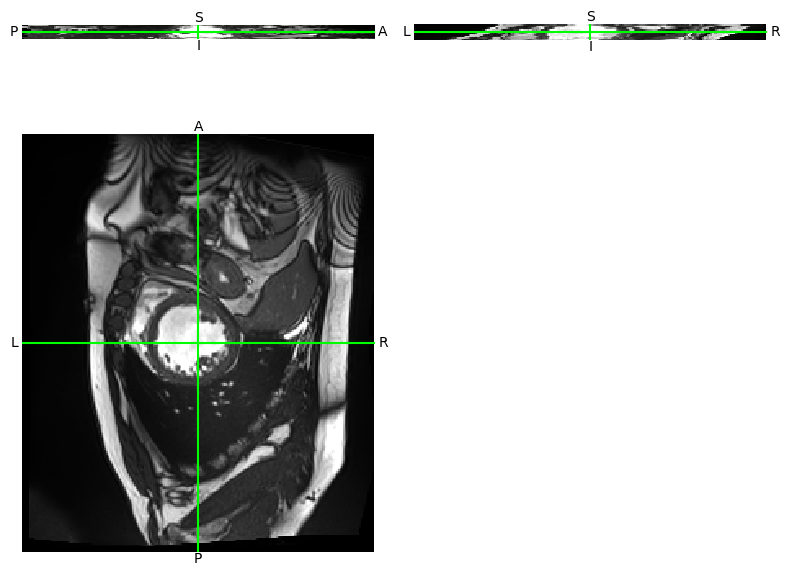

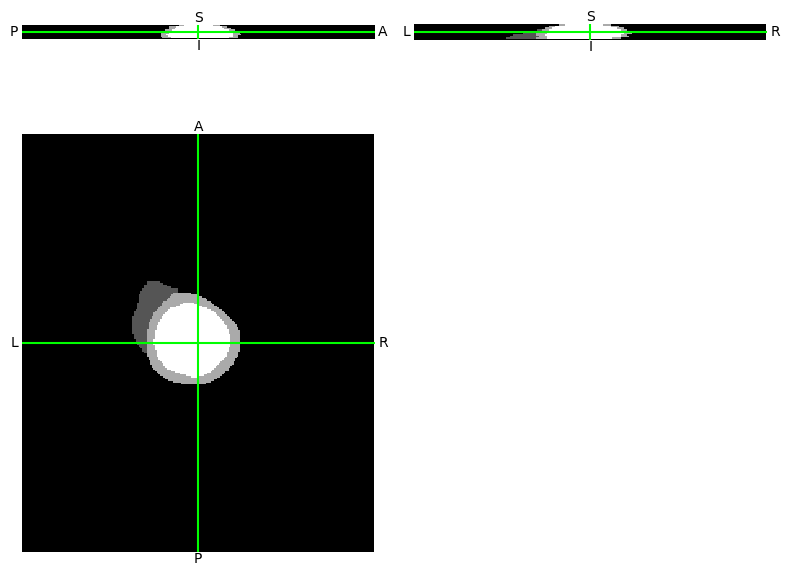

In [24]:
from nibabel.viewers import OrthoSlicer3D
x,y,z = img.shape[0] // 2, img.shape[1] // 2, img.shape[2] // 2
plot = OrthoSlicer3D(img.get_fdata(), title="Center slice of MRI data")
plot.set_position(x,y,z)
plt.tight_layout()
plot.show()


plot = OrthoSlicer3D(label.get_fdata(), title="Center slice of MRI data")
plot.set_position(x,y,z)
plt.tight_layout()
plot.show()

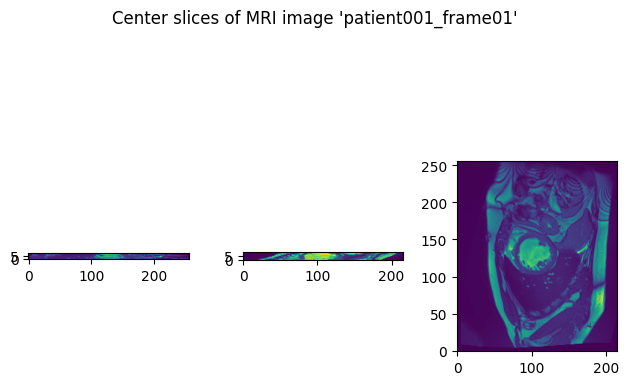

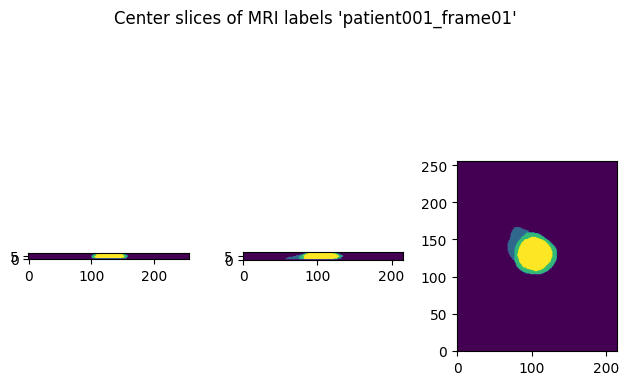

In [28]:
import matplotlib.pyplot as plt

def show_slices(slices):
    fig, axes = plt.subplots(1, len(slices))
    for i, s in enumerate(slices):
        axes[i].imshow(s.T, origin="lower")

img_data = img.get_fdata()
x,y,z = img.shape[0] // 2, img.shape[1] // 2, img.shape[2] // 2
show_slices([
    img_data[x, :, :],
    img_data[:, y, :],
    img_data[:, :, z]
])
plt.suptitle(f"Center slices of MRI image '{name}'")
plt.tight_layout()
plt.show()

label_data = label.get_fdata()
show_slices([
    label_data[x, :, :],
    label_data[:, y, :],
    label_data[:, :, z]
])
plt.suptitle(f"Center slices of MRI labels '{name}'")
plt.tight_layout()
plt.show()

In [29]:
print(im.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          :

In [30]:
# Code for the task here

allFiles = train_files + val_files + test_files

# 1) Create an empty list that will contain the voxel resolutions of all the images

# 2) Iterate over all paths in trainFiles, valFiles and testFiles
# 2.1) Open the images, gather their voxel size/resolution, put it in the list
voxelDims = [nib.load(file['image']).header.get_zooms() for file in allFiles]
voxelDims = np.array(voxelDims)

# 3) Find the maximum and minimum voxel resolution across all images in each dimension
#    (i.e., maximum and minimum voxel size in the first dimension, second dimension,
#     and third dimension, 6 numbers in total)
smallestVoxelDims = np.min(voxelDims, axis=0)
largestVoxelDims = np.max(voxelDims, axis=0)

# Follow the same steps for the image size
imageDims = [nib.load(file['image']).header.get_data_shape() for file in allFiles]
imageDims = np.array(imageDims)

# 3) Find the maximum and minimum voxel resolution across all images in each dimension
#    (i.e., maximum and minimum voxel size in the first dimension, second dimension,
#     and third dimension, 6 numbers in total)
smallestImDims = np.min(imageDims, axis=0)
largestImDims = np.max(imageDims, axis=0)

print(smallestVoxelDims)
print(largestVoxelDims)
print(smallestImDims)
print(largestImDims)

[ 1.3671875  1.3671875 10.       ]
[ 1.875  1.875 10.   ]
[184 216   8]
[256 256  11]


## 2. Preprocessing

Carefully-curated datasets, such as MNIST, are good to learn and practice deep learning because they're very simple and easy to use; MNIST particularly has become the "hello world" of deep learning algorithms. However, real-world datasets typically need some preprocessing to ensure that images have the same size, resolution, distribution, etc. You can do a lot of preprocessing on the fly (i.e., during training) using MONAI transforms. This has the advantage that you can easily and programmatically change any detail of that preprocessing. The disadvantage of this, however, is that you'll need to do this fixed operations every time in your experiments. On the other hand, if you preprocess your data before training, you only need to do it once, and you'll save a lot of time overall. To familiarize with MONAI, and since we're not running these experiments many times, we will **preprocess the images during training with MONAI**.

### 2.1 Standardizing the voxel resolution

At this point, you've probably realized that voxel resolution is different across images. This typically happens when the images are acquired with different acquisition parameters. If your goal is to train a neural network that is agnostic to the voxel resolution, you'd probably be fine not standardizing it across all images. A much simpler task would be if we standardize the voxel resolution so that all images have the same voxel resolution. What's typically done in practice is what we'll do here: 1) standardizing all the images (including the images in the test set), 2) computing the segmentations, and 3) resampling back the segmentations to the original voxel resolution. MONAI has a transform that does this for us: Spacingd https://docs.monai.io/en/stable/transforms.html#spacingd

Let's check it out in detail:

In [6]:
# Size of the first image
dummy_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
])

In [7]:
dummy_dataset = Dataset(data=train_files, transform=dummy_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False)

first_image = next(iter(dummy_loader))
print("Original size: ", first_image['image'].shape)

Original size:  torch.Size([1, 1, 216, 256, 10])


In [8]:
# Size of the first image after changing its voxel resolution
dummy_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=(1.464845, 1.464845, 10),
                              mode=["bilinear", "nearest"]), # It is important that the mode is "nearest" for the label.
])

dummy_dataset = Dataset(data=train_files, transform=dummy_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False) 

first_image = next(iter(dummy_loader))
print("Size after changing its voxel resolution: ", first_image['image'].shape)

Size after changing its voxel resolution:  torch.Size([1, 1, 230, 273, 10])


Note that, in Pytorch, neural networks are trained with tensors that have the following shape: BxCxHxW (2D images) and BxCxHxWxD (3D images), where B = batch size, C = number of channels, and HxW(xD) is the height x width x depth of the image (or image patch). As you can see after running the code above, MONAI's (and Pytorch's) DataLoaders provide us directly the tensors following this convention.

> ---
> **Task:**
> 
> * Investigate and decide the voxel resolution that is the most suitable for the images. A good solution is resizing all images to the median voxel resolution of the dataset. Can you come up with other ways? **Note**: Write down your solution; we will use it later when training the neural network.
> * [Discussion]: Note that the 'image' is resampled using 'bilinear' interpolation whereas the 'label' is resampled using 'nearest (neighbor)' interpolation. What would happen if we set the mode of 'label' in Spacingd from "nearest" to "bilinear"? More importantly, what are the consequences of that?
> 
> ---

In [9]:
print(np.median([x[0] for x in all_resolutions]))
print(np.median([x[1] for x in all_resolutions]))
print(np.median([x[2] for x in all_resolutions]))

# If we change the Spacing to bilinear, we will have floats instead of ints.
print(torch.unique(first_image['label']))

1.464845
1.464845
10.0
metatensor([0., 1., 2., 3.])


### 2.2 Standardizing the image size

You also probably noticed that images don't have the same size either. In fact, even if the had the same size, **after changing their voxel resolution their size would change**; for this reason, images need to be resampled before their size is standardized. Standardizing the image size is necessary to be able to put various images in a training batch. Luckily, MONAI has a transform that can help us with this: ResizeWithPadOrCrop. We simply need to give an image size, and MONAI will either crop the center of the image to achieve that size (if the image is too large), or it will pad the image evenly (if the image is too small). Read more here: https://docs.monai.io/en/stable/transforms.html#resizewithpadorcropd

Finding out the appropriate image size is a bit more tricky than finding out a good voxel resolution. Think that, if you set a very large image size, the image will be padded with a lot of unnecessary zeroes and the neural network will perform more (unnecessary) computations. On the other hand, if you set a very small image size, the image will be excessively cropped, and you might lose important information (and even the area that we're interested in).

Importantly, an image size must be **compatible** with the neural network, otherwise, the neural network will give you errors at execution time. What does "compatible" mean? How to figure this out? Whether an image size is compatible with a neural network depends mostly, but not exclusively, on the number of times the feature maps are downsampled. It may also depend on other characteristics of the neural network architecture, as we will see in a moment.

There are two main ways to downsample feature maps in neural networks: with Pooling operations (read more here: https://towardsai.net/p/l/introduction-to-pooling-layers-in-cnn), or directly with convolutional layers by setting their "**strides**" parameter to a value larger than 1. "strides" controls how far you jump between slides during the convolution (see image below for a graphical explanation). In practice, with MONAI's default parameters, a convolution with strides=1 gives you an output of the same size as the input; with strides=2 downsamples the image by half; and so on. 

[<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*y3Ydr1oCHRfOegWxZITIOA.png" width="700px">](https://miro.medium.com/v2/resize:fit:720/format:webp/1*y3Ydr1oCHRfOegWxZITIOA.png)

Consider the following convolutional neural network:

In [10]:
# Read more: https://docs.monai.io/en/stable/networks.html#dynunet
model = DynUNet(spatial_dims=2, # 2 for 2D convolutions, 3 for 3D convolutions
                in_channels=1, # Number of input channels/modalities (3 for RGB)
                out_channels=4, # Number of classes, including background
                kernel_size=[3, 3, 3, 3, 3, 3], # Size of the filters
                strides=[1, 2, 2, 2, 2, 2],
                upsample_kernel_size=[2, 2, 2, 2, 2]
                ).cuda()

# Feeding the network with some random values to verify that the input size is compatible with the network.
res = model(torch.rand((1, 1, 512, 512)).cuda())
print(res.shape)

# This won't work because the input was too small
#res = model(torch.rand((1, 1, 16, 16)).cuda())
#print(res.shape)

torch.Size([1, 4, 512, 512])


`model` downsamples the input image five times by a factor of 2⁵=32 (multiply the values of `strides`: 1\*2\*2\*2\*2\*2=32). Therefore, we cannot give as an input an image of size 16x16. We would expect that this model works if the image size is 32x32 because, after downsampling it, it will become of size 1x1. Let's try it:

In [11]:
res = model(torch.rand((1, 1, 32, 32)).cuda())

ValueError: Expected more than 1 spatial element when training, got input size torch.Size([1, 512, 1, 1])

> ---
> **Task:**
> 
> Come up with an image size to standardize all the images with ResizeWithPadOrCrop. Note that:
> * The image size must be **compatible** with the neural network. *Hint: figure out the number of times that the network downsamples the feature maps. Look at the last three lines of the previous cell*.
> 
> **Important remarks**:
> * Don't worry too much about the values of the image size that you come up with. We mostly care about "how" you found this parameter values and not at the actual value. At the end, the results you get after training the network will tell you whether your choice was good.
> * As we will see below, here, we only care about standardizing the image size in the Height and Width dimensions. For example, if we want our images to have a fixed size of 512x512xD (and we don't care about "D"), we will initialize the transform in the following way: ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[512, 512, -1]). "-1" indicates "use the same value as in the original image".
> * Work with the image sizes **after** standardizing the voxel resolution.
>
> ---

But it didn't work!

As mentioned above, the number of times that the image is downsampled is one (probably the most important) factor to consider when investigating which image size is compatible. But it is not the only factor. If you look at the error trace, you'll see that the error is raised when applying Instance normalization once the feature maps have a height and width of 1x1. This is because Instance normalization layer normalizes the values across their HxW(xD). In other words, it would be like normalizing a vector with only one single value.

If we use Batch normalization instead of Instance normalization and the batch size is larger than 1, the model won't raise any error. On the contrary, if the batch size is 1, we would end up having a similar issue as before, i.e., trying to normalize across a single value.

In [13]:
model_ = DynUNet(spatial_dims=2, # 2 for 2D convolutions, 3 for 3D convolutions
                in_channels=1, # Number of input channels/modalities (3 for RGB)
                out_channels=4, # Number of classes, including background
                kernel_size=[3, 3, 3, 3, 3, 3], # Size of the filters
                strides=[1, 2, 2, 2, 2, 2],
                upsample_kernel_size=[2, 2, 2, 2, 2],
                norm_name="BATCH").cuda() # Here, we specify that the normalization layer is Batch Normalization

# This works
res = model_(torch.rand((2, 1, 32, 32)).cuda())
print(res.shape)

# This won't work
#res = model_(torch.rand((1, 1, 32, 32)).cuda())
#print(res.shape)

torch.Size([2, 4, 32, 32])


> ---
> **Task:**
> 
> Come up with an image size to standardize all the images with ResizeWithPadOrCrop. As aforementioned, note that the image size must be **compatible** with the neural network. **Note**: Write down your solution; we will use it later when training the neural network.
> 
> **Important remarks**:
> * As we will see below, here, we only care about standardizing the image size in the Height and Width dimensions. For example, if we want our images to have a fixed size of 512x512xD (and we don't care about "D"), we will initialize the transform in the following way: ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[512, 512, -1]). "-1" indicates "use the same value as in the original image".
> * **Work with the image sizes <font color="red">after</font> standardizing their voxel resolution**.
>
> ---

In [31]:
np.median(imageDims, axis=0)

array([216., 256.,  10.])

In [32]:
# Code for the task here

# Similarly to the previous task, iterate over all images, load them, and get their size.
# Code for the task here

new_voxel_dims = np.median(voxelDims, axis=0)
new_img_dims = 256, 256, -1
print(new_voxel_dims)

[ 1.464845  1.464845 10.      ]


In [34]:
transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(
        keys=['image','label'],
        pixdim=new_voxel_dims,
        mode=["bilinear", "nearest"]
    ),
    monai.transforms.ResizeWithPadOrCropd(
        keys=['image', 'label'],
        spatial_size=new_img_dims
    )
])
train_dataset = Dataset(data=train_files, transform=transforms)
val_dataset = Dataset(data=val_files, transform=transforms)
test_dataset = Dataset(data=test_files, transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True) 
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

first_image = next(iter(train_dataset))
print("Size after changing its voxel resolution: ", first_image['image'].shape)


# With this information, and with what we've learned in this subsection, you can find out a good image size
# Try that image size on the model to test whether it works
# res = model(torch.rand((1, 1, 128, 128)))
# print(res.shape)

Size after changing its voxel resolution:  torch.Size([1, 256, 256, 10])


## 3. Data augmentation

### 3.1 Data augmentation

> ---
> **Task:**
> 
> Figure out which Data Augmentation (DA) transforms (and which parameters) make sense to use in this dataset. You have all the transformations available in MONAI here: https://docs.monai.io/en/stable/transforms.html#dictionary-transforms but pay special attention to the "Intensity" and "Spatial" type of transformations. **Note:**
> * Try to guess based on what you know about the images (their appearance) and the task.
> * Don't spend too much time on this. Finding out a good DA strategy can take a lot of time. But try **at least three transformations** (one of them "spatial"-based, and another one "intensity"-based)
> 
> **Important remark**: As in the previous task, we care more about how you found this and not about the actual transformations and their parameters.
> 
> ---

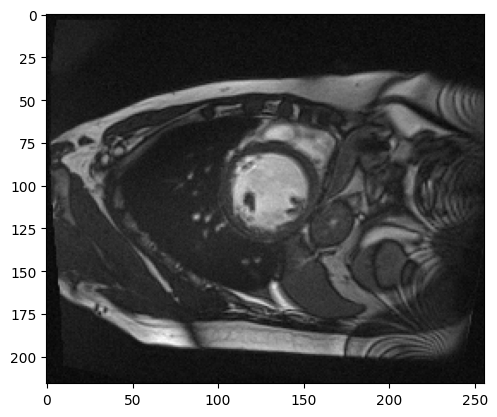

In [36]:
# Code for the task here

# Example: I want to check if "RandAdjustContrast" is a good transform. For this, I need to apply it and visualize the data-augmented images.
# Because I always want to apply it, I set the probability to 1 (note that, during training, the probability should not be 1; perhaps, 0.5).
# Everytime RandAdjustContrast is called during training, it will choose a random gamma value within certain range. Thus, we need to find
# the appropiate values of this range.
# I'm guessing that "0.7" is a good minimum for this range:

# Since each element in "trainFiles" is a dictionary with keys "image" and "label", in MONAI, I can specify
# to which element each transform will be applied. This way, I can apply certain transforms to the images, and certain
# transforms to the labels.
# Note that the names of the following transforms always end in "d", which stands for "dictionary"
# and requires us to set the parameter "keys".
dummy_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.NormalizeIntensityd(keys=['image']), # standardize images: mean zero, std one.
    
    monai.transforms.RandRotated(keys=['image', 'label'], range_z = 180, prob = 0.5, mode='nearest'),
    monai.transforms.RandGaussianSmoothd(keys=['image'], sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), approx='erf', prob=0.5),
    monai.transforms.RandGaussianNoised(keys=['image'], prob=0.5, mean=0.0, std=0.5)
    # check_this_transform,
])
dummy_dataset = Dataset(data=train_files, transform=dummy_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False) 

first_image = next(iter(dummy_loader)) # first_image['image'], first_image['label']
# print(first_image['image'].shape) # Batch size x Channels x Height x Width x Depth

plt.imshow(first_image['image'][0, 0, :, :, 4], cmap="gray")

# I'm happy with what I see. Next would be finding out what's the maximum value of the range in RandAdjustContrastd
# Don't forget to try other data augmentation functions.

### 3.2 Sampling slices from the images

(Although this is not "data augmentation", we include this part here because it is a MONAI transform).

Images from datasets, especially 3D images, can be so big that they won't fit in GPU memory. The most common solution to tackle this is training the neural network with random patches and, at inference time, making predictions on every patch of the image and combining them. At the beginning of this exercise, we said that we will train a 2D network on this dataset. A simple way to do this is with RandSpatialCropd by sampling patches of size (Height x Width x 1), where Height and Width are the values we will set in RandSpatialCropd. Or even simpler: we could just set the size to (-1, -1, 1), where -1 tells the transform to use the same size as the given image.

Importantly, note that, if our original images were of size BxCxHxWxD, and we sample patches of size (-1, -1, 1), the sampled slices will be of size BxCxHxWx1. We need to "squeeze" the last dimension, as you can see from the code below.

In [39]:
# Here, we get the 3D images
dummy_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
])
dummy_dataset = Dataset(data=train_files, transform=dummy_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False) 

for i, data in enumerate(dummy_loader):
    if i > 10:
        break
    print(data["image"].shape)

print("^^ No squeezing ==== Sampling and squeezing vv")

# Now, we add the RandSpatialCrop
dummy_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[-1, -1, 1]),
    monai.transforms.SqueezeDimd(keys=['image', 'label'], dim=-1) # Without this, the images will be BxCxHxWx1
])
dummy_dataset = Dataset(data=train_files, transform=dummy_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=False) 

for i, data in enumerate(dummy_loader):
    if i > 10:
        break
    print(data["image"].shape)

torch.Size([1, 1, 216, 256, 10])
torch.Size([1, 1, 216, 256, 10])
torch.Size([1, 1, 232, 256, 10])
torch.Size([1, 1, 232, 256, 10])
torch.Size([1, 1, 256, 256, 10])
torch.Size([1, 1, 256, 256, 10])
torch.Size([1, 1, 232, 256, 10])
torch.Size([1, 1, 232, 256, 10])
torch.Size([1, 1, 256, 216, 10])
torch.Size([1, 1, 256, 216, 10])
torch.Size([1, 1, 232, 256, 11])
^^ No squeezing ==== Sampling and squeezing vv
torch.Size([1, 1, 216, 256])
torch.Size([1, 1, 216, 256])
torch.Size([1, 1, 232, 256])
torch.Size([1, 1, 232, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 232, 256])
torch.Size([1, 1, 232, 256])
torch.Size([1, 1, 256, 216])
torch.Size([1, 1, 256, 216])
torch.Size([1, 1, 232, 256])


> ---
> **Task:**
> 
> [Discussion] Find out what's the difference between RandSpatialCropd, RandSpatialCropSamplesd, and RandCropByLabelClassesd. Think in which case they can be used (especially RandCropByLabelClassesd). https://docs.monai.io/en/stable/transforms.html
> 
> ---

### 3.3 Data augmentation, preprocessing, and "postprocessing" for the validation and test sets

For the validation and test set, we should apply the same "preprocessing" data-augmentation operations we did on the training set. After all, our network will learn how to make predictions on images with the characteristics (size, resolution) of our training set. This means that we should keep the "Spacing" and "CropOrPad", and, on the other hand, we don't need the data augmentations that changes the appearance of the image.

In summary, during validation and at test time, our predictions 1) will have a **size** different from the original images (that we indicated in PadOrCrop), 2) will have a **voxel resolution** different from the original images (indicated in Spacing), and 3) will be just **slices** and not the entire 3D images. Therefore, before measuring how well the network performed, we must postprocess the predictions. Think that, at test time, the segmentations must correspond to the original images (i.e., have the same size and resolution), and, during validation, we want to measure how good the network is, so, it must be as close as "at test time" as possible.

How can we postprocess our predictions to make them with similar properties as of the original images? MONAI provides a relatively simple solution to this problem. Certain MONAI's transformations can be "inverted", meaning that if we, for instance, resample an image to have certain voxel resolution, we can then invert it back to the original voxel resolution. See an example of this below.

In [41]:
dummy_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=(2, 2, 10), mode=["bilinear", "nearest"]),])

dummy_dataset = Dataset(data=train_files, transform=dummy_transforms)
dummy_loader = DataLoader(dummy_dataset, batch_size=1, shuffle=True)

for data in dummy_loader:
    transformed_label = data['label']
    print("Transformed label size: ", transformed_label.shape)
    break

transformed_label.applied_operations = data["label"].applied_operations
seg_dict = {"label": transformed_label}
batch_inverter = BatchInverseTransform(dummy_transforms, dummy_loader)
with allow_missing_keys_mode(dummy_transforms):
    inversed_label = batch_inverter(seg_dict)
print("Inversed label size: ", inversed_label[0]['label'].shape)

Transformed label size:  torch.Size([1, 1, 169, 200, 10])
Inversed label size:  torch.Size([1, 216, 256, 10])


> ---
> **Task:**
> 
> [Discussion] Does it make sense to apply data augmentation at validation time and/or when generating the final predictions on the test set?
> 
> ---

## 4. Combining all Data augmentation and preprocessing transforms

**ALWAYS** check the data you're feeding to the network. Visualize a few slices. Does your input data make sense?

In [44]:
train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=new_voxel_dims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=[256, 256, -1]),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[-1, -1, 1]),
    monai.transforms.SqueezeDimd(keys=['image', 'label'], dim=-1),
    # TODO: Add more Data Augmentation functions here
    monai.transforms.RandRotated(keys=['image', 'label'], range_z = 180, prob = 0.5, mode='nearest'),
    monai.transforms.RandGaussianSmoothd(keys=['image'], sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), approx='erf', prob=0.5),
    monai.transforms.RandGaussianNoised(keys=['image'], prob=0.5, mean=0.0, std=0.5),

    monai.transforms.AsDiscreted(keys=['label'], to_onehot=4) # Convert "label" to onehot encoded.
])

BATCH_SIZE = 4
train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

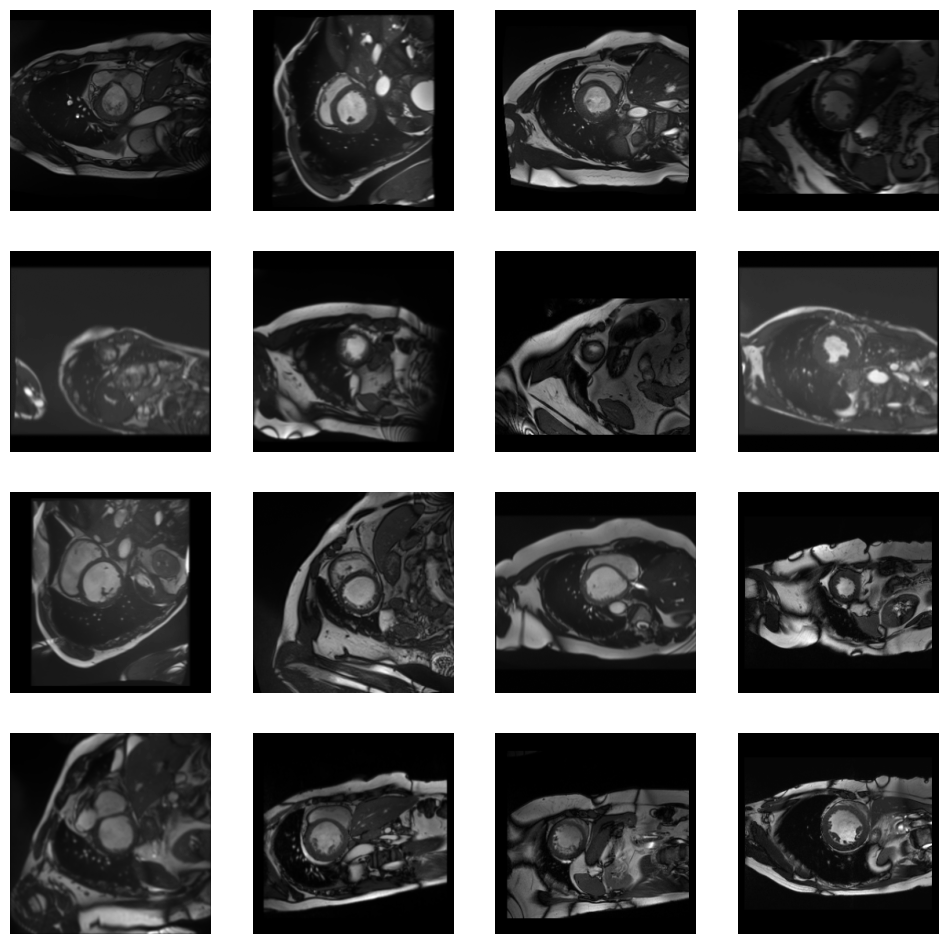

In [45]:
# Visualize a few image slices after being data-augmented

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, data in enumerate(train_loader):
    if i > 3:
        break
    for b in range(data['image'].shape[0]):
        axes[i, b].imshow(data['image'][b,0], cmap="gray")
        axes[i, b].axis('off')

# Part 2: Training, Validation, and Inference

## 5. Training a neural network

Here, you have some code to train a neural network. To make the following cell self-contained, it includes many lines from previous cells. **Remember** to include your data transformations where it's indicated.

> ---
> **Task:**
> 
> Play around with the batch size, number of epochs, loss functions, models, optimizers, and their corresponding hyper-parameters. **Note**: Don't spend too much time on this. Find in MONAI's documentation what models, loss functions, and optimizers are available.
> 
> ---

In [47]:
spatialSize = 256,256,-1 #TODO: Should be defined further up

train_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=new_voxel_dims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=spatialSize),
    monai.transforms.RandSpatialCropd(keys=['image', 'label'], roi_size=[-1, -1, 1]),
    monai.transforms.SqueezeDimd(keys=['image', 'label'], dim=-1),
    # TODO: Add more Data Augmentation functions here
    monai.transforms.RandRotated(keys=['image', 'label'], range_z = 180, prob = 0.5, mode='nearest'),
    monai.transforms.RandGaussianSmoothd(keys=['image'], sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5), approx='erf', prob=0.5),
    monai.transforms.RandGaussianNoised(keys=['image'], prob=0.5, mean=0.0, std=0.5),

    monai.transforms.AsDiscreted(keys=['label'], to_onehot=4) # Convert "label" to onehot encoded.
])

val_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=new_voxel_dims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=spatialSize),
])

# Hyper-parameters (next three lines) #
BATCH_SIZE = 4
NUM_EPOCHS = 30
EVAL_EVERY = 1

train_dataset = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# More design decisions (model, loss, optimizer) #
model = DynUNet(
    spatial_dims=2, 
    in_channels=1, 
    out_channels=4,
    kernel_size=[3, 3, 3, 3, 3, 3],
    strides=[1, 2, 2, 2, 2, 2], 
    upsample_kernel_size=[2, 2, 2, 2, 2]
).cuda()
loss_fn = monai.losses.DiceLoss(softmax=True, to_onehot_y=False) # Apply "softmax" to the output of the network and don't convert to onehot because this is done already by the transforms.
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

inferer = monai.inferers.SliceInferer(roi_size=[-1, -1], spatial_dim=2, sw_batch_size=1)

all_losses = []
all_dices = []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}')

    model.train()
    epoch_loss = 0
    step = 0
    for tr_data in train_loader:
        inputs = tr_data['image'].cuda()
        targets = tr_data['label'].cuda()

        # Forward -> Backward -> Step
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.detach()
        step += 1
        
    # Log and store average epoch loss
    epoch_loss = epoch_loss.item() / step
    all_losses.append(epoch_loss)
    print(f'Mean loss: {epoch_loss}')

    if epoch % EVAL_EVERY == 0:
        model.eval()
        with torch.no_grad():  # Do not need gradients for this part
            for val_data in val_loader:
                inputs = val_data['image'].cuda()
                targets = val_data['label'].cuda()

                # Gets the prediction in the entire 3D image. Shape = BCHWD
                prediction = inferer(inputs=inputs, network=model)

                # Inverses the transformations, i.e., it:
                # - Unpads/Uncrops the image
                # - Resamples back to the original voxel resolution
                batch_inverter = BatchInverseTransform(val_transforms, val_loader)
                with allow_missing_keys_mode(val_transforms):
                    inversed_prediction = batch_inverter({"label": prediction}) # Shape: inversed_prediction[B]['label'].shape = CHWD
                    inversed_targets = batch_inverter({"label": targets}) # Shape: inversed_targets[B]['label'].shape = 1HWD

                # Applying argmax on that prediction
                inversed_prediction = [monai.transforms.AsDiscrete(argmax=True)(pred['label']) for pred in inversed_prediction]

                val_dices = []
                # Compute the dice coefficients
                for b in range(prediction.shape[0]):
                    dices_tmp = []
                    for c in range(1, prediction.shape[1]): # Iterate over each class (except the first one, that corresponds to the background)
                        dices_tmp.append( metric.dc( 1*(inversed_prediction[b].cpu().detach().numpy()==c),
                                                   1*(inversed_targets[b]['label'].cpu().detach().numpy()==c) ) )
                    val_dices.append( dices_tmp )

        # Log and store the average Dice coefficient across images; one value per class
        all_dices.append(np.mean(val_dices, axis=0))
        print(f'Dice coefficients: {all_dices[-1]}')

Epoch 1
Mean loss: 0.8675500324794224
Dice coefficients: [0.02834156 0.12414236 0.3590533 ]
Epoch 2
Mean loss: 0.8066389901297433
Dice coefficients: [0.04104411 0.21711531 0.41310651]
Epoch 3
Mean loss: 0.7823176383972168
Dice coefficients: [0.04489205 0.20695421 0.44107525]
Epoch 4
Mean loss: 0.751220566885812
Dice coefficients: [0.12255775 0.16825367 0.56044884]
Epoch 5
Mean loss: 0.7300098964146206
Dice coefficients: [0.1063598  0.33034562 0.68123067]
Epoch 6
Mean loss: 0.7189438683646066
Dice coefficients: [0.0711544  0.44510549 0.66537139]
Epoch 7
Mean loss: 0.6913203511919294
Dice coefficients: [0.10620855 0.34735562 0.62779508]
Epoch 8
Mean loss: 0.692953245980399
Dice coefficients: [0.10132533 0.5405622  0.78436567]
Epoch 9
Mean loss: 0.6484289169311523
Dice coefficients: [0.10233743 0.30271372 0.46416466]
Epoch 10
Mean loss: 0.5775398526872907
Dice coefficients: [0.09782379 0.09225451 0.30368903]
Epoch 11
Mean loss: 0.5674159867422921
Dice coefficients: [0.09814724 0.32696527 

## 6. Training and validation curves

> ---
> **Tasks:**
> 
> * Make one Figure where you plot the training loss over time.
> * Make another Figure where you plot the validation dice coefficients of the three classes over time.
>
> Note: Don't spend too much time on this. It should take less than 10 lines of code.
> 
> ---

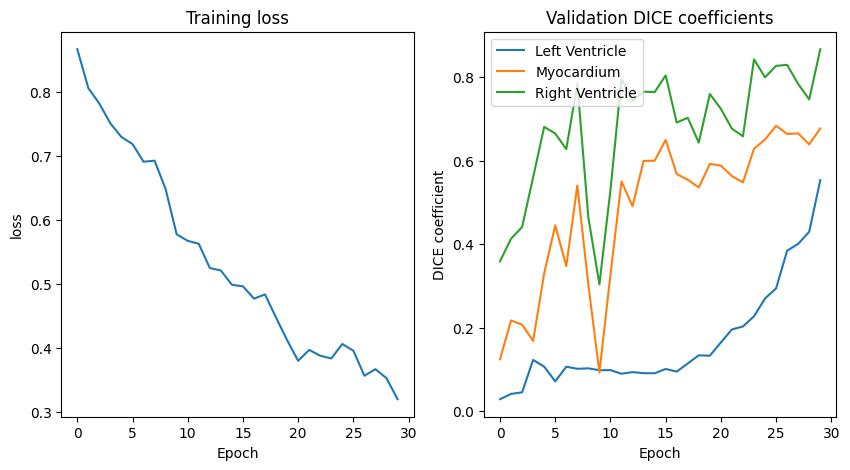

In [48]:
# Code for the task here
# plt.plot(all_losses)
ad = np.array(all_dices)

fig, axs = plt.subplots(1,2, figsize = (10,5))
axs[0].set_title("Training loss")
axs[0].plot(all_losses)
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("loss")

axs[1].set_title("Validation DICE coefficients")
axs[1].plot(ad[:,0], label = "Left Ventricle")
axs[1].plot(ad[:,1], label = "Myocardium")
axs[1].plot(ad[:,2], label = "Right Ventricle")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("DICE coefficient")
plt.legend()
plt.show()

## 7. Inference at test time

Now you've trained a model that learned from the training set and hopefully worked well on the validation set. It is time to use the test data.

> ---
> **Task:**
> 
> Complete the code from below to compute the segmentations using your trained model. *Hint: the code is almost the same as in the validation*.
>
> **Important remark**: Fill the list "test_dices", which is a list of lists. E.g., test_dices = [ [id1, dice1, dice2, dice3], [id2, dice1, dice2, dice3], ...]. Here, idN is the name of the file (e.g., patient019_frame12) that you get from `test_data['id']`, and each dice corresponds to the Dice coefficient in each class except in 'class 0' (background).
> 
> ---

In [50]:
test_transforms = monai.transforms.Compose([
    monai.transforms.LoadImaged(keys=['image', 'label']),
    monai.transforms.EnsureChannelFirstd(keys=['image', 'label']),
    monai.transforms.Spacingd(keys=['image', 'label'], pixdim=new_voxel_dims, mode=["bilinear", "nearest"]),
    monai.transforms.ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=spatialSize),
])

test_dataset = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

test_dices = []
for test_data in test_loader:
    inputs = test_data['image'].cuda()
    targets = test_data['label'].cuda()
    ids = test_data['id']

    with torch.no_grad():
        prediction = inferer(inputs=inputs, network=model)

    # COMPLETE THE CODE
    # Inverses the transformations, i.e., it:
    # - Unpads/Uncrops the image
    # - Resamples back to the original voxel resolution
    batch_inverter = BatchInverseTransform(test_transforms, test_loader)
    with allow_missing_keys_mode(test_transforms):
        inversed_prediction = batch_inverter({"label": prediction}) # Shape: inversed_prediction[B]['label'].shape = CHWD
        inversed_targets = batch_inverter({"label": targets}) # Shape: inversed_targets[B]['label'].shape = 1HWD

    # Applying argmax on that prediction
    inversed_prediction = [monai.transforms.AsDiscrete(argmax=True)(pred['label']) for pred in inversed_prediction]

    val_dices = []
    # Compute the dice coefficients
    for b in range(prediction.shape[0]):
        dices_tmp = []
        for c in range(1, prediction.shape[1]): # Iterate over each class (except the first one, that corresponds to the background)
            dices_tmp.append( metric.dc( 1*(inversed_prediction[b].cpu().detach().numpy()==c),
                                       1*(inversed_targets[b]['label'].cpu().detach().numpy()==c) ) )

        test_dices.append([ids[0]] + dices_tmp)
                    
# Checking that your "test_dices" has the right format.
assert len(test_dices) == 8 # The test set has 8 images
for line in test_dices:
    assert len(line) == 4 # Each line consists of "frame ID" and the dice coefficient in the three foreground classes.

for frameid, dice1, dice2, dice3 in test_dices:
    print(f"Frame ID: {frameid}. Dice coeff. (Class 1): {dice1}. Dice coeff. (Class 2): {dice2}. Dice coeff. (Class 3): {dice3}")

avg_dice = np.mean([[d1, d2, d3] for _, d1, d2, d3 in test_dices])
print(f"Final average dice: {avg_dice}")

Frame ID: patient017_frame01. Dice coeff. (Class 1): 0.714872637633525. Dice coeff. (Class 2): 0.6542906135838366. Dice coeff. (Class 3): 0.8778374507697816
Frame ID: patient017_frame09. Dice coeff. (Class 1): 0.691461045967916. Dice coeff. (Class 2): 0.7057893980749892. Dice coeff. (Class 3): 0.8749342078626665
Frame ID: patient018_frame10. Dice coeff. (Class 1): 0.5003213003213003. Dice coeff. (Class 2): 0.6257874842503149. Dice coeff. (Class 3): 0.8107050298831121
Frame ID: patient018_frame01. Dice coeff. (Class 1): 0.574487895716946. Dice coeff. (Class 2): 0.6006260869565218. Dice coeff. (Class 3): 0.8858152624460055
Frame ID: patient019_frame11. Dice coeff. (Class 1): 0.3233497920997921. Dice coeff. (Class 2): 0.7518564664839272. Dice coeff. (Class 3): 0.8804587560652846
Frame ID: patient019_frame01. Dice coeff. (Class 1): 0.5101425086660676. Dice coeff. (Class 2): 0.7580071174377224. Dice coeff. (Class 3): 0.9118390979734877
Frame ID: patient020_frame01. Dice coeff. (Class 1): 0.

## 8. Visualize the results

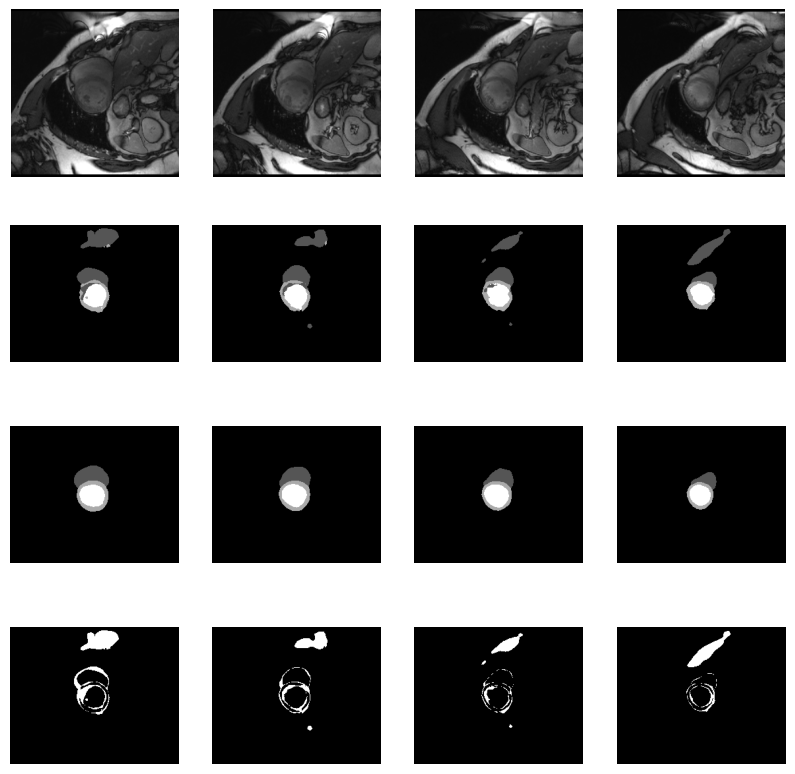

In [53]:
# Assuming 'inputs', 'inversed_prediction', and 'inversed_targets' are your tensors from model inference
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

slices = [1, 2, 3, 4]  # Example slice indices
inputs_cpu = inputs.cpu().detach().numpy()
inversed_prediction_cpu = inversed_prediction[0].cpu().detach().numpy()
inversed_targets_cpu = inversed_targets[0]['label'].cpu().detach().numpy()

for i, sl in enumerate(slices):
    # Image slices
    axes[0, i].imshow(inputs_cpu[0, 0, :, :, sl], cmap="gray")
    axes[0, i].axis('off')
    
    # Predictions by our trained model
    axes[1, i].imshow(inversed_prediction_cpu[0, :, :, sl], cmap="gray")
    axes[1, i].axis('off')
    
    # Ground truth
    axes[2, i].imshow(inversed_targets_cpu[0, :, :, sl], cmap="gray")
    axes[2, i].axis('off')
    
    # Error maps
    error_map = inversed_targets_cpu[0, :, :, sl] != inversed_prediction_cpu[0, :, :, sl]
    axes[3, i].imshow(error_map, cmap="gray")
    axes[3, i].axis('off')

# # Save the figure
# plt.savefig('Medical_Imaging_Comparison.png')  # Adjust path as necessary
# plt.close(fig)  # Close the figure to free up memory